In [1]:
# Comment out !pip line if not running on google colab
!pip install pingouin
import os
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
from pingouin import ancova
from scipy import stats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Comment out lines below if not using google colab
from google.colab import drive
drive.mount('/content/drive')
DATASET_DIR = '/content/drive/MyDrive/Signals/Paper/'
file_dir = DATASET_DIR + 'Anger_and_gait.xlsx'

# If running locally, uncomment this line
# file_dir = './Anger_and_gait.xlsx'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load dataset
cols = [60,89,92,104,106] # CurrentPOMSAnger, Sex, Age, Height, Weight
cols.extend(range(867, 1037)) # 170 Gait Features
cols.extend(range(1048, 1081)) # 33 Balance (Feet Apart, Eyes Open, Firm Surface) Features
cols.extend(range(1088, 1121)) # 33 Balance (Feet Apart, Eyes Closed, Firm Surface) Features
cols.extend(range(1128, 1161)) # 33 Balance (Feet Apart, Eyes Open, Foam Surface) Features
cols.extend(range(1168, 1201)) # 33 Balance (Feet Apart, Eyes Closed, Foam Surface) Features

df = pd.read_excel(file_dir, usecols=cols)
df.drop(df.loc[(df['CurrentPOMSAnger'] > 0) & (df['CurrentPOMSAnger'] < 3)].index, inplace=True) # Drop all CurrentPOMSAnger socres of 1 and 2
for key in df.keys(): # Replace missing values with mean
    df[key].replace([np.nan], df[key].median(), inplace=True)
df['CurrentPOMSAnger'] = df['CurrentPOMSAnger'] >=3 # Change CurrentPOMSAnger to a True/False (Angry/Not Angry)
df_not_std = df.copy() # Copy of df for calculating averages later
df.iloc[:,1:-1] = df.iloc[:,1:-1].apply(lambda x: (x-x.mean())/ x.std(), axis=0) # Standardize by mean and standard deviation
df

,CurrentPOMSAnger,Sex,Age_A,Heightcm,WeightinKG,AnticipatoryPosturalAdjustmentAPADurations,AnticipatoryPosturalAdjustmentFirstStepDurations,AnticipatoryPosturalAdjustmentFirstStepRangeofMotiondegrees,AnticipatoryPosturalAdjustmentForwardAPAPeakms2,AnticipatoryPosturalAdjustmentLateralAPAPeakms2,...,PosturalSwayAccRangeCoronalms2_C,PosturalSwayAccRangeSagittalms2_C,PosturalSwayAnglesSwayAreaRadiusCoronaldegrees_C,PosturalSwayAngles95EllipseAxis2Radiusdegrees_C,PosturalSwayAnglesSwayAreaRotationdegrees_C,PosturalSwayAnglesSwayAreadegrees2_C,PosturalSwayAnglesDurations_C,PosturalSwayAnglesRMSSwaydegrees_C,PosturalSwayAnglesRMSSwayCoronaldegrees_C,PosturalSwayAnglesRMSSwaySagittaldegrees_C
0,False,0.784478,-0.692213,-0.703342,-1.784747,-0.627168,-0.738473,-1.192365,-0.157698,2.914893,...,-0.997898,-1.370485,-0.623015,-1.293967,0.164618,-0.796355,-0.319577,-1.228014,-0.735630,0.3302
1,True,-1.262819,-0.692213,0.225764,-0.119637,-0.627168,-0.326928,0.477160,-0.858335,1.425430,...,0.455803,-0.680671,0.090070,-0.756977,-1.472393,-0.389215,-0.319577,-0.612338,0.152456,0.4302
2,False,0.784478,-0.692213,-1.013044,0.493824,-0.083162,-0.944246,-0.498194,-0.040925,2.368757,...,0.002421,0.969473,0.147693,1.024347,0.475616,0.436901,-0.319577,0.892552,0.155829,0.8341
3,True,0.784478,-0.692213,-0.393640,-0.265700,0.072268,-1.047132,2.440421,1.535508,0.829645,...,-0.738823,-0.378595,-0.356509,-0.297758,0.021080,-0.360779,-0.319577,-0.351662,-0.485144,0.5501
4,True,-1.262819,-0.571779,0.225764,-0.481872,-0.122020,-0.944246,-0.522045,-0.741562,0.779996,...,-0.803592,-0.969221,-0.601406,-0.795863,0.270562,-0.624205,3.099894,-0.824566,-0.702738,0.4392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,False,0.784478,-0.210478,-1.013044,-0.996011,-1.443177,0.084617,0.508542,0.951644,-0.908062,...,0.340659,0.658381,0.936407,0.228121,-0.764958,0.450703,-0.319577,0.390922,0.875238,0.6570
126,False,0.784478,-0.210478,0.225764,-0.587037,0.111125,-1.355790,-0.355092,0.367780,-0.064033,...,-0.328620,-0.459750,-0.266473,-0.794011,0.824207,-0.517694,-0.319577,-0.738817,-0.296226,0.4330
128,True,-1.262819,-0.812646,1.464573,-0.587037,-0.432880,0.907707,-1.690712,-0.799948,-0.014384,...,1.895112,1.695357,2.416598,1.318766,0.082596,2.036128,-0.319577,1.646712,2.172367,0.9065
129,True,0.784478,1.957329,-1.322747,1.568843,0.188840,-0.429814,-0.897374,-0.332857,-0.957711,...,-0.098330,-0.468767,-0.050386,-0.490334,-0.327511,-0.321575,-0.319577,-0.439983,-0.173091,0.5065


In [4]:
# Normality tests for Height, Weight, and Age
_, pHeight = stats.mannwhitneyu(df_not_std[df_not_std['CurrentPOMSAnger'] == True]['Heightcm'], df_not_std[df_not_std['CurrentPOMSAnger'] == False]['Heightcm'])
_, pWeight = stats.mannwhitneyu(df_not_std[df_not_std['CurrentPOMSAnger'] == True]['WeightinKG'], df_not_std[df_not_std['CurrentPOMSAnger'] == False]['WeightinKG'])
_, pAge = stats.mannwhitneyu(df_not_std[df_not_std['CurrentPOMSAnger'] == True]['Age_A'], df_not_std[df_not_std['CurrentPOMSAnger'] == False]['Age_A'])

print('p-value Height: {0}\np-value Weight: {1}\np-value Age: {2}'.format(pHeight, pWeight, pAge))

p-value Height: 0.8227961748433735
p-value Weight: 0.5910377244076315
p-value Age: 0.6234953673583555


In [5]:
# Split train and test data (80/20) and rank features by importance
train, test = \
              np.split(df.sample(frac=1, random_state=21), 
                       [int(.8*len(df))])
              
# Split features and Anger value
train_x = train.iloc[:, 5:]
train_y = train['CurrentPOMSAnger']
test_x = test.iloc[:, 5:]
test_y = test['CurrentPOMSAnger']

# Train RF for feature importance
forest = RandomForestClassifier(random_state=0)
forest.fit(train_x, train_y)

# Sort importances
importances = list(zip(train_x.keys(),forest.feature_importances_))
importances.sort(key = lambda x : x[1], reverse=True)

# Create new input features for top 5 importances
top_train_x = train_x[[i[0] for i in importances[:5]]]
top_test_x = test_x[[i[0] for i in importances[:5]]]

# Setting hyperparameters for RF and GB
max_depth=[2, 8, 16, 32]
n_estimators = [32, 64, 128, 256, 512]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# Show top 5 ranked features
importances[:5]

[('PosturalSwayAccFrequencyDispersionCoronalAD_C', 0.02416989929231783),
 ('PosturalSwayAccCentroidalFrequencySagittalHz_B', 0.019946330356654177),
 ('AsymmetryterminaldoublelegsupportofGCT', 0.0177521212059248),
 ('PosturalSwayAcc95EllipseSwayAream2s4', 0.017490984888319044),
 ('PosturalSwayAccCentroidalFrequencyHz_B', 0.01610978279195832)]

{'max_depth': 2, 'n_estimators': 32}


([<matplotlib.axis.YTick at 0x7fb1cf8f8ac0>,
 [Text(0, 0.5, 'False'), Text(0, 1.5, 'True')])

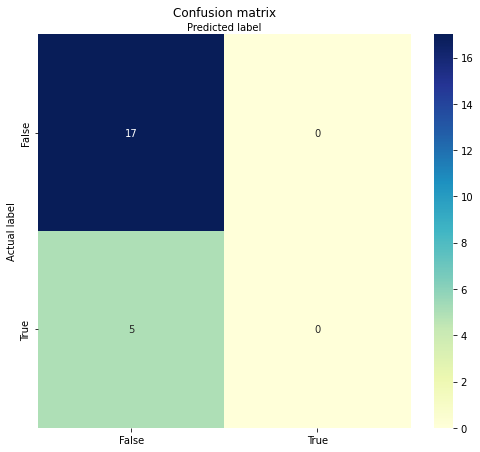

In [6]:
# RF All Features

# Setup classifier and grid search
rf_all_classifier = RandomForestClassifier(random_state=0)
grid = GridSearchCV(estimator=rf_all_classifier, param_grid=param_grid, cv = 10)
grid_results = grid.fit(train_x, train_y)

# Print best parameters and get best esitmator
print(grid_results.best_params_)
best_rf_all = grid_results.best_estimator_

pred_y = best_rf_all.predict(test_x)

# Create confusion matrix
cnf_matrix = confusion_matrix(test_y, pred_y)
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

{'max_depth': 2, 'n_estimators': 256}


([<matplotlib.axis.YTick at 0x7fb1cf8dee50>,
 [Text(0, 0.5, 'False'), Text(0, 1.5, 'True')])

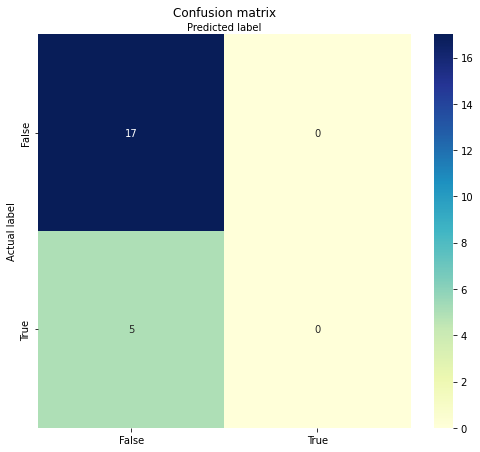

In [7]:
# RF Top 5 Features

# Setup classifier and grid search
rf_top_classifier = RandomForestClassifier(random_state=0)
grid = GridSearchCV(estimator=rf_top_classifier, param_grid=param_grid, cv = 10)
grid_results = grid.fit(top_train_x, train_y)

# Print best parameters and get best esitmator
print(grid_results.best_params_)
best_rf_top = grid_results.best_estimator_

test_y = test['CurrentPOMSAnger']

pred_y = best_rf_top.predict(top_test_x)

# Create confusion matrix
cnf_matrix = confusion_matrix(test_y, pred_y)
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

{'max_depth': 2, 'n_estimators': 128}


([<matplotlib.axis.YTick at 0x7fb1cf9122b0>,
 [Text(0, 0.5, 'False'), Text(0, 1.5, 'True')])

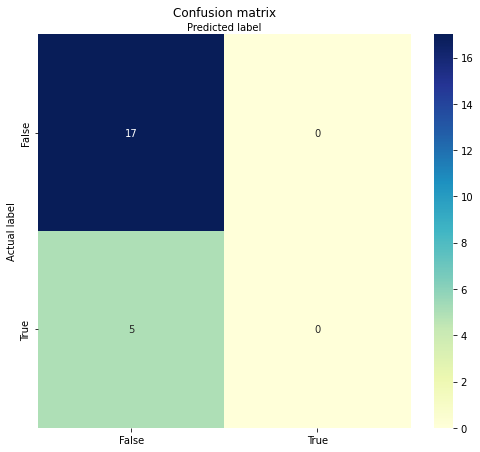

In [8]:
# GB All Features

# Setup classifier and grid search
gb_all_classifier = GradientBoostingClassifier(random_state=0)
grid = GridSearchCV(estimator=gb_all_classifier, param_grid=param_grid, cv = 10)
grid_results = grid.fit(train_x, train_y)

# Print best parameters and get best esitmator
print(grid_results.best_params_)
best_gb_all = grid_results.best_estimator_

pred_y = best_gb_all.predict(test_x)

# Create confusion matrix
cnf_matrix = confusion_matrix(test_y, pred_y)
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

{'max_depth': 2, 'n_estimators': 32}


([<matplotlib.axis.YTick at 0x7fb1cf64f9a0>,
 [Text(0, 0.5, 'False'), Text(0, 1.5, 'True')])

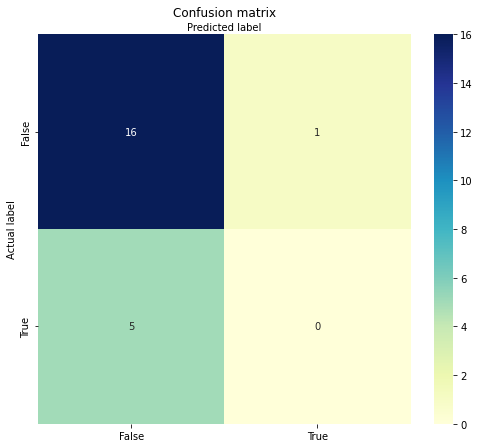

In [9]:
# GB Top 5 Features

# Setup classifier and grid search
gb_top_classifier = GradientBoostingClassifier(random_state=0)
grid = GridSearchCV(estimator=gb_top_classifier, param_grid=param_grid, cv = 10)
grid_results = grid.fit(top_train_x, train_y)

# Print best parameters and get best esitmator
print(grid_results.best_params_)
best_gb_top = grid_results.best_estimator_

pred_y = best_gb_top.predict(top_test_x)

# Create confusion matrix
cnf_matrix = confusion_matrix(test_y, pred_y)
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

In [10]:
# ANCOVA on features while accounting for Age, Height, and Weight
covar = ['Age_A', 'Heightcm', 'WeightinKG']
for key in df.keys()[1:]:
  if(key not in covar):
    res = ancova(data=df, dv=key, between='CurrentPOMSAnger', covar=covar)

    # Print name, mean, and standard deviation for all featues with p-value < 0.05
    if (res['p-unc'][0] < 0.05):
      print(key)
      print('Angry Mean: \t\t{0} \tAngry Std: \t{1}\nNot Angry Mean: \t{2} \tNot Angry std: \t{3}'.format(df_not_std[df_not_std['CurrentPOMSAnger'] == True][key].mean(), df_not_std[df_not_std['CurrentPOMSAnger'] == True][key].std(), df_not_std[df_not_std['CurrentPOMSAnger'] == False][key].mean(), df_not_std[df_not_std['CurrentPOMSAnger'] == False][key].std()))

GaitJointBackFlexExtMin.degreesmean
Angry Mean: 		0.044375000000000275 	Angry Std: 	5.785344667058884
Not Angry Mean: 	-2.7249999999999996 	Not Angry std: 	4.536610518878604
GaitJointNeckLeftLat.BendMax.degreesstd
Angry Mean: 		3.095625 	Angry Std: 	2.1256496065908888
Not Angry Mean: 	2.270879120879121 	Not Angry std: 	1.1099966449915746
GaitJointNeckFlexExtMax.degreesstd
Angry Mean: 		7.380624999999999 	Angry Std: 	5.1038305467560345
Not Angry Mean: 	5.492307692307692 	Not Angry std: 	2.356433310899748
GaitJointNeckFlexExtMin.degreesstd
Angry Mean: 		7.026875 	Angry Std: 	4.226974834323006
Not Angry Mean: 	5.411758241758242 	Not Angry std: 	2.109151273962846
GaitJointNeckFlexExtRangedegreesstd
Angry Mean: 		4.43375 	Angry Std: 	2.3394639699441124
Not Angry Mean: 	3.425824175824175 	Not Angry std: 	1.3819825259661214
Asymetrymidswingelevation
Angry Mean: 		10.337816188024739 	Angry Std: 	8.530376341543688
Not Angry Mean: 	19.26830040681762 	Not Angry std: 	15.659429405834079
GaitLumbar